In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
import nltk
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

[nltk_data] Downloading package punkt to C:\Users\RUPIKASREE
[nltk_data]     K\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns = {'v1':'label','v2':'message'})

In [4]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.shape

(5572, 2)

In [6]:
df['label_num']=df.label.map({'ham':0,'spam':1})

In [7]:
df.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [8]:
df.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

Text(0.5, 1.0, 'Number of ham and spam messages')

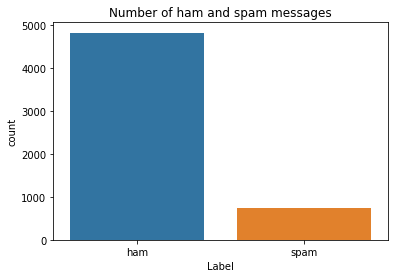

In [9]:
sns.countplot(df.label)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [10]:
df['length'] = df['message'].apply(len)

In [11]:
df.head()

,label,message,label_num,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


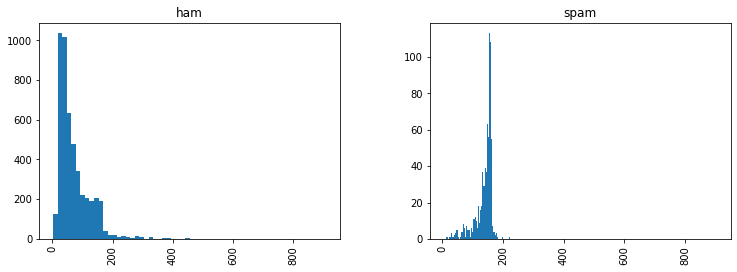

In [12]:
df.hist(column='length',by='label',bins=60,figsize=(12,4));
plt.xlim(-40,950);

Here we can see that spam messages are longer than ham messages.

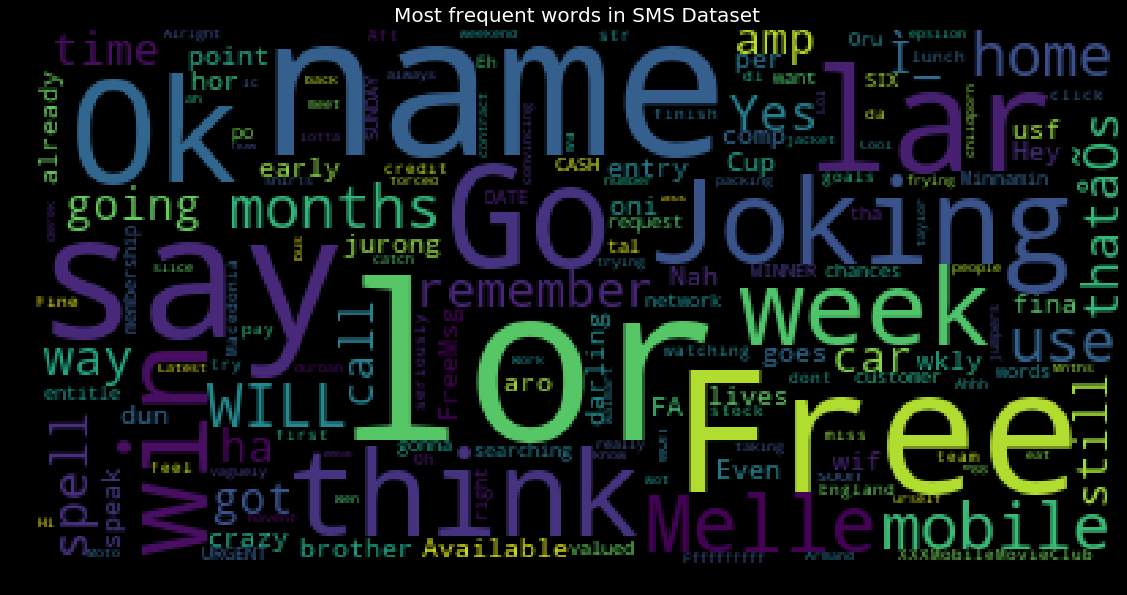

In [13]:
wc=WordCloud()
wc.generate(str(df['message']))
plt.figure(figsize=(20,10),facecolor='k')
plt.title('Most frequent words in SMS Dataset',fontsize=20,color='white')
plt.imshow(wc)
plt.show()

In [14]:
df_ham  = df[df['label_num'] == 0].copy()
df_spam = df[df['label_num'] == 1].copy()

In [15]:
import wordcloud

In [16]:
def show_wordcloud(data_spam_or_ham, title):
    text = ' '.join(data_spam_or_ham['message'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='lightgrey',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20 )
    plt.show()


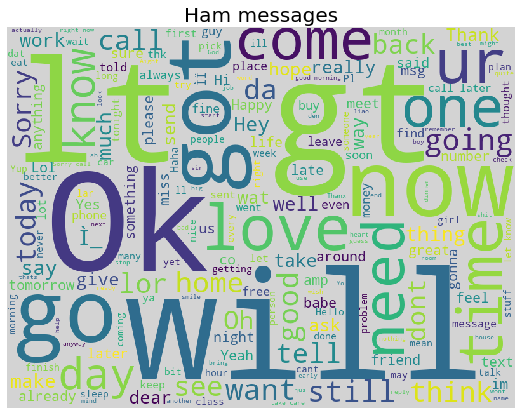

In [17]:
show_wordcloud(df_ham, "Ham messages")

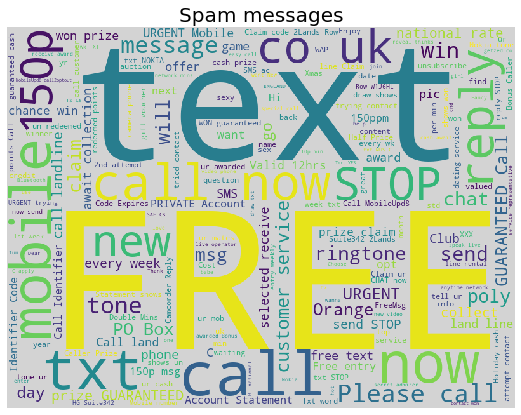

In [18]:
show_wordcloud(df_spam, "Spam messages")

### Punctuation and stop words removal

In [19]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\RUPIKASREE
[nltk_data]     K\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
from nltk.corpus import stopwords
stopwords.words("english")[50:60]

['been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing']

In [22]:
def puncstop(sms):
    
    nopunc = [ch for ch in sms if ch not in string.punctuation]
    nopunc = "".join(nopunc).split()
    
    nopuncnostop = \
        [word.lower() for word in nopunc if word.lower() not in stopwords.words("english")]
        
    return nopuncnostop

In [23]:
df['message'].apply(puncstop).head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

### Using counter getting most common ham and spam words

In [24]:
from collections import Counter

In [25]:
df_ham.loc[:, 'message'] = df_ham['message'].apply(puncstop)
words_df_ham = df_ham['message'].tolist()
df_spam.loc[:, 'message'] = df_spam['message'].apply(puncstop)
words_df_spam = df_spam['message'].tolist()

In [26]:
list_ham_words = []
for sublist in words_df_ham:
    for item in sublist:
        list_ham_words.append(item)

In [27]:
list_spam_words = []
for sublist in words_df_spam:
    for item in sublist:
        list_spam_words.append(item)

In [28]:
c_ham  = Counter(list_ham_words)
c_spam = Counter(list_spam_words)
df_hamwords_top30  = pd.DataFrame(c_ham.most_common(30),  columns=['word', 'count'])
df_spamwords_top30 = pd.DataFrame(c_spam.most_common(30), columns=['word', 'count'])

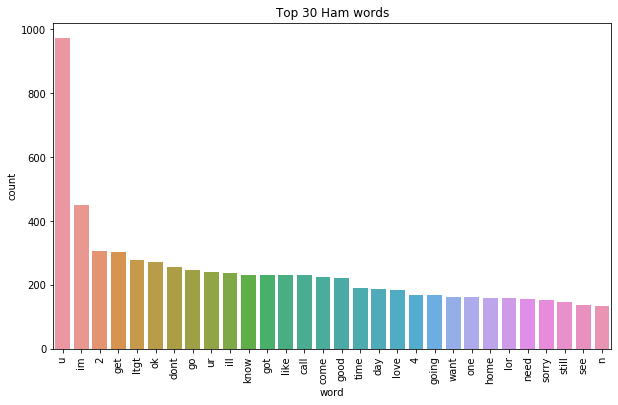

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', data=df_hamwords_top30, ax=ax)
plt.title("Top 30 Ham words")
plt.xticks(rotation='vertical');

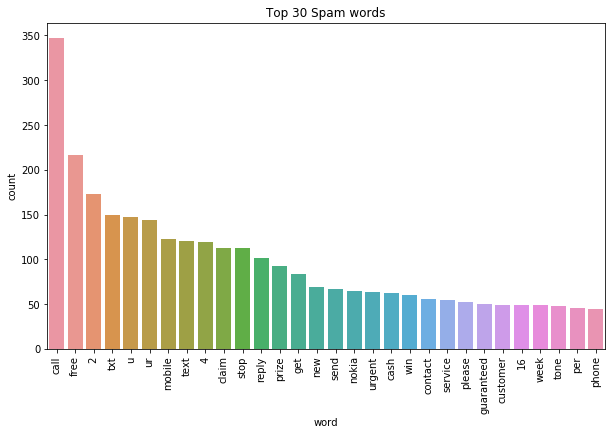

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', data=df_spamwords_top30, ax=ax)
plt.title("Top 30 Spam words")
plt.xticks(rotation='vertical');

In [31]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def cleanText(message):
    
    message = message.translate(str.maketrans('', '', string.punctuation))
    words = [stemmer.stem(word) for word in message.split() if word.lower() not in stopwords.words("english")]
    
    return " ".join(words)

df["message"] = df["message"].apply(cleanText)
df.head(n = 10) 

,label,message,label_num,length
0,ham,Go jurong point crazi avail bugi n great world...,0,111
1,ham,Ok lar joke wif u oni,0,29
2,spam,free entri 2 wkli comp win FA cup final tkt 21...,1,155
3,ham,U dun say earli hor U c alreadi say,0,49
4,ham,nah dont think goe usf live around though,0,61
5,spam,freemsg hey darl 3 week word back Id like fun ...,1,148
6,ham,even brother like speak treat like aid patent,0,77
7,ham,per request mell mell oru minnaminungint nurun...,0,160
8,spam,winner valu network custom select receivea å£9...,1,158
9,spam,mobil 11 month U R entitl updat latest colour ...,1,154


### Train test split

In [32]:
X=df.message
y=df.label_num
print(X.shape)
print(y.shape)

(5572,)
(5572,)


In [33]:
type(y)

pandas.core.series.Series

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state=7)

In [35]:
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (4179,)
X_test (1393,)
y_train (4179,)
y_test (1393,)


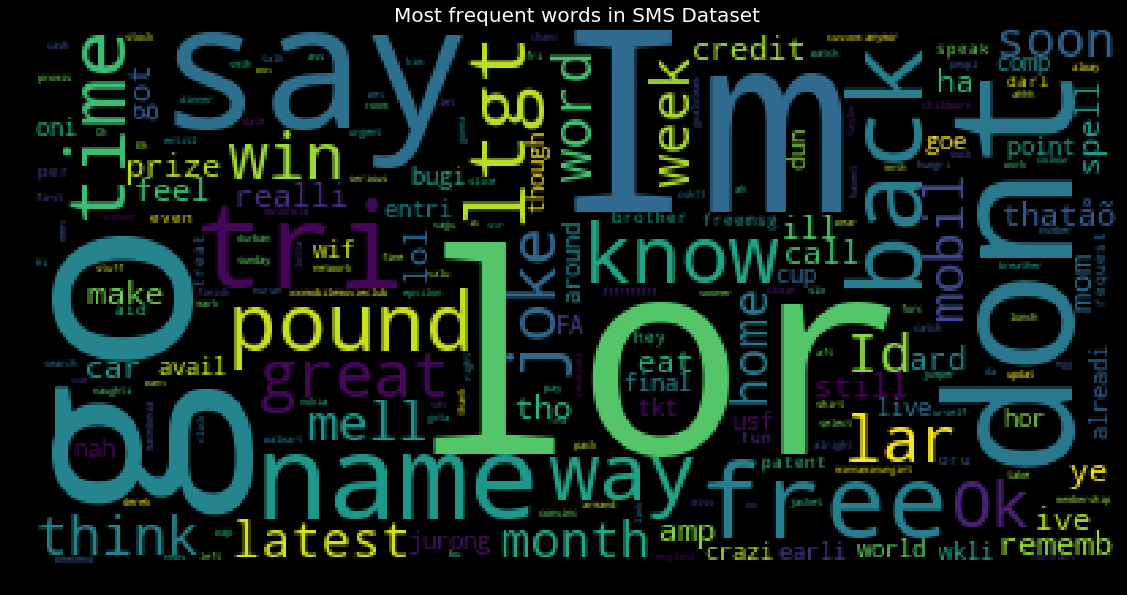

In [36]:
wc=WordCloud()
wc.generate(str(df['message']))
plt.figure(figsize=(20,10),facecolor='k')
plt.title('Most frequent words in SMS Dataset',fontsize=20,color='white')
plt.imshow(wc)
plt.show()

### Bag of words with Countvectorizer

In [37]:
tonumeric=CountVectorizer()
tonumeric.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [38]:
X_train_dtm=tonumeric.transform(X_train)
X_train_dtm

<4179x6898 sparse matrix of type '<class 'numpy.int64'>'
	with 35329 stored elements in Compressed Sparse Row format>

In [39]:
X_test_dtm=tonumeric.transform(X_test)
X_test_dtm

<1393x6898 sparse matrix of type '<class 'numpy.int64'>'
	with 10415 stored elements in Compressed Sparse Row format>

In [40]:
#no fo columns in both train and test is same 
#no of rows in train is 4719, test is 1393

### Base model

In [41]:
from sklearn.naive_bayes import MultinomialNB

In [42]:
nb=MultinomialNB()
nb.fit(X_train_dtm,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [43]:
y_pred=nb.predict(X_test_dtm)

In [44]:
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score

In [45]:
accuracy_score(y_test,y_pred)

0.9856424982053122

In [46]:
#without impying any imbalance technique, we got 98.7%

In [47]:
nb.score(X_test_dtm,y_test) #built model

0.9856424982053122

In [48]:
confusion_matrix(y_test,y_pred)

array([[1205,    6],
       [  14,  168]], dtype=int64)

In [49]:
y_pred_prob=nb.predict_proba(X_test_dtm)[:,1]
y_pred_prob

array([2.42255328e-03, 3.03992892e-01, 5.13409146e-03, ...,
       4.03472976e-05, 8.92496431e-04, 8.53260784e-04])

In [50]:
roc_auc_score(y_test,y_pred_prob)

0.9781081841362601

### Other model comparision

In [51]:
lr=LogisticRegression()
lr.fit(X_train_dtm,y_train)
y_pred=lr.predict(X_test_dtm)
accuracy_score(y_test,y_pred)

0.9755922469490309

In [52]:
y_pred_prob=nb.predict_proba(X_test_dtm)[:,1]
y_pred_prob

array([2.42255328e-03, 3.03992892e-01, 5.13409146e-03, ...,
       4.03472976e-05, 8.92496431e-04, 8.53260784e-04])

In [53]:
roc_auc_score(y_test,y_pred_prob)

0.9781081841362601

In [54]:
confusion_matrix(y_test,y_pred)

array([[1209,    2],
       [  32,  150]], dtype=int64)

In [55]:
dt=DecisionTreeClassifier()
dt.fit(X_train_dtm,y_train)
y_pred=dt.predict(X_test_dtm)
accuracy_score(y_test,y_pred)

0.9605168700646087

In [56]:
accuracy_score(y_test,y_pred)

0.9605168700646087

In [57]:
y_pred_prob=nb.predict_proba(X_test_dtm)[:,1]
roc_auc_score(y_test,y_pred_prob)

0.9781081841362601

In [58]:
confusion_matrix(y_test,y_pred)

array([[1199,   12],
       [  43,  139]], dtype=int64)

In [59]:
rf=RandomForestClassifier()
rf.fit(X_train_dtm,y_train)
y_pred=rf.predict(X_test_dtm)
accuracy_score(y_test,y_pred)

0.9676956209619526

In [60]:
y_pred_prob=nb.predict_proba(X_test_dtm)[:,1]
roc_auc_score(y_test,y_pred_prob)

0.9781081841362601

In [61]:
confusion_matrix(y_test,y_pred)

array([[1211,    0],
       [  45,  137]], dtype=int64)

In [62]:
knn=KNeighborsClassifier()
knn.fit(X_train_dtm,y_train)
y_pred=knn.predict(X_test_dtm)
accuracy_score(y_test,y_pred)

0.9102656137832017

In [63]:
y_pred_prob=nb.predict_proba(X_test_dtm)[:,1]
roc_auc_score(y_test,y_pred_prob)

0.9781081841362601

In [64]:
confusion_matrix(y_test,y_pred)

array([[1211,    0],
       [ 125,   57]], dtype=int64)

### Bag of words with TF-IDF

In [65]:
tonumericTFIDF=TfidfVectorizer()

In [66]:
tonumericTFIDF.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [67]:
X_train_dtm=tonumericTFIDF.transform(X_train)
X_train_dtm

<4179x6898 sparse matrix of type '<class 'numpy.float64'>'
	with 35329 stored elements in Compressed Sparse Row format>

In [68]:
X_test_dtm=tonumericTFIDF.transform(X_test)
X_test_dtm

<1393x6898 sparse matrix of type '<class 'numpy.float64'>'
	with 10415 stored elements in Compressed Sparse Row format>

### Base model

In [69]:
nb=MultinomialNB()
nb.fit(X_train_dtm,y_train)
y_pred=nb.predict(X_test_dtm)
accuracy_score(y_test,y_pred)

0.95908111988514

In [70]:
y_pred_prob=nb.predict_proba(X_test_dtm)[:,1]
roc_auc_score(y_test,y_pred_prob)

0.9824502499977315

In [71]:
confusion_matrix(y_test,y_pred)

array([[1211,    0],
       [  57,  125]], dtype=int64)

In [72]:
lr=LogisticRegression()
lr.fit(X_train_dtm,y_train)
y_pred=lr.predict(X_test_dtm)
accuracy_score(y_test,y_pred)

0.9597989949748744

In [73]:
y_pred_prob=nb.predict_proba(X_test_dtm)[:,1]
roc_auc_score(y_test,y_pred_prob)

0.9824502499977315

In [74]:
confusion_matrix(y_test,y_pred)

array([[1206,    5],
       [  51,  131]], dtype=int64)

In [75]:
dt=DecisionTreeClassifier()
dt.fit(X_train_dtm,y_train)
y_pred=dt.predict(X_test_dtm)
accuracy_score(y_test,y_pred)

0.9404163675520459

In [76]:
y_pred_prob=nb.predict_proba(X_test_dtm)[:,1]
roc_auc_score(y_test,y_pred_prob)

0.9824502499977315

In [77]:
confusion_matrix(y_test,y_pred)

array([[1189,   22],
       [  61,  121]], dtype=int64)

In [78]:
rf=RandomForestClassifier()
rf.fit(X_train_dtm,y_train)
y_pred=rf.predict(X_test_dtm)
accuracy_score(y_test,y_pred)

0.964824120603015

In [79]:
y_pred_prob=nb.predict_proba(X_test_dtm)[:,1]
roc_auc_score(y_test,y_pred_prob)

0.9824502499977315

In [80]:
confusion_matrix(y_test,y_pred)

array([[1209,    2],
       [  47,  135]], dtype=int64)

In [81]:
knn=KNeighborsClassifier()
knn.fit(X_train_dtm,y_train)
y_pred=knn.predict(X_test_dtm)
accuracy_score(y_test,y_pred)

0.9109834888729361

In [82]:
y_pred_prob=nb.predict_proba(X_test_dtm)[:,1]
roc_auc_score(y_test,y_pred_prob)

0.9824502499977315

In [83]:
confusion_matrix(y_test,y_pred)

array([[1211,    0],
       [ 124,   58]], dtype=int64)